In [15]:
%matplotlib widget

import time
import IPython
import numpy as np
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Video

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

In [16]:
class kmeans:
    def __init__(self, dimensions, sample_size, clusters, tolerance, max_iters):
        """
        Use the initialisation parameters as attributes of the object and create
        a matplotlib figure canvas on which each iteration progress can be drawn
        :param dimesnions: Dimension of data
        :param sample_size: Not necessary for real data, here used for generating sample data
        :param clusters: Number of clusters to identify in the data, control the number of Means 
        :param tolerance: The tolearance value
        :param max_iters: Maximum iterations to execute
        """
        self.dimensions = dimensions
        self.sample_size = sample_size
        self.clusters = clusters
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.colors = ['y', 'r', 'b', 'm', 'k', 'c', 'b', 'm', 'k', 'c']
        
        if self.dimensions == 1:
            self.fig, self.ax = plt.subplots(1,1)
            self.sample_pts = np.array([[]])
            self.ax.grid(True)
        elif self.dimensions == 2:
            self.fig, self.ax = plt.subplots(1,1)
            self.sample_pts = np.array([[], []])
            self.ax.grid(True)
        elif self.dimensions == 3:
            self.fig = plt.figure(1, figsize=(8, 6))
            self.sample_pts = np.array([[], [], []])
            self.ax = Axes3D(self.fig, rect=(0.0, 0.0, .95, 1.0), elev=48, azim=134)
    
    def kmeans_init(self):
        """
        Generate sample data and draw the initial state of the data and display the initial position
        of the Means
        """
        ##################################################################################################################################
        # Creating clusters using normal distribution and random variance and mean
        # every cluster will have equal number of points
        ##################################################################################################################################
        for i in range(0, self.clusters):
            np.random.seed(int((-i) ** 2))
            tmp = np.random.randn(1, (self.sample_size // self.clusters) * self.dimensions) * np.random.randint(1, 10) + np.random.randint(-100, 100)
            self.sample_pts = np.hstack((self.sample_pts, tmp.reshape(self.dimensions, self.sample_size // self.clusters)))
        np.random.seed(22)
        self.previous_means = np.random.randn(self.clusters, self.dimensions) * np.random.randint(1, 12)  # Randomly selected means i.e., cluster centers
        # print(f'Starting means are: {self.previous_means}')
        self.new_means = np.zeros((self.clusters, self.dimensions))  # To store the new means after every iteration
    
        ##################################################################################################################################
        # plot initial means and all data samples to see the distribution
        ##################################################################################################################################
        if self.dimensions == 1:
            self.ax.scatter(self.previous_means[:, 0], np.zeros((self.clusters, 1)), marker='o', c='r', label='Initial Means')
            self.ax.scatter(self.sample_pts[0, :], np.zeros((1, self.sample_size)),
                        marker='*')  # Plotting all the points to see the clusters
        elif self.dimensions == 2:
            self.ax.scatter(self.previous_means[:, 0], self.previous_means[:, 1], marker='o', c='r', label='Initial Means')
            self.ax.scatter(self.sample_pts[0, :], self.sample_pts[1, :], marker='*')  # Plotting all the points to see the clusters
        elif self.dimensions == 3:
            self.ax.scatter(self.previous_means[:, 0], self.previous_means[:, 1], self.previous_means[:, 2], marker='o', c='r',
                       label='Initial Means', depthshade=False)
            self.ax.scatter(self.sample_pts[0, :], self.sample_pts[1, :], self.sample_pts[2, :],
                       marker='*')  # Plotting all the points to see the clusters
        self.ax.legend(loc='upper right')
    
    ##################################################################################################################################
    # Loop till convergence
    ##################################################################################################################################
    def kmeans_iter(self, iteration_count):
        """
        Iteration part of the algorithm which iterates until the tolerance criteria is met while
        limiting the maximum number of iterations to preven infinite loops when the algorithm 
        cannot associate a Mean value with a cluster
        """
        if (abs(self.previous_means - self.new_means) > self.tolerance).any() and (iteration_count < self.max_iters) and (iteration_count != 0):
            print(f'Iteration number {iteration_count}')
            if iteration_count != 1:
                self.previous_means = self.new_means.copy()
            dist = pd.DataFrame()
            
            ##################################################################################################################################
            # Compute distances of all points with respect to each mean
            ##################################################################################################################################
            for i in range(0, self.clusters):
                # distance_to_mean_1_iter_1 naming used
                dist['dtm_' + str(i + 1) + f'_iter_{iteration_count}'] = LA.norm(
                    self.sample_pts - self.previous_means[i, :].T.reshape(self.dimensions, 1), axis=0)
            # Assign a data sample to the mean it is nearest to by extracting the digit in the name of the index i.e., column
            # name where the minimum value is found
            # dtm_{1}_iter_1
            dist['assign_to_mean'] = dist.idxmin(axis=1).str[4]
            
            ##################################################################################################################################
            # compute the new means based on the classes assigned
            ##################################################################################################################################
            for i in range(0, self.clusters):
                indices = dist.assign_to_mean[dist.assign_to_mean == str(i + 1)]
                if self.dimensions > 1:
                    if len(indices.index) != 0:
                        self.new_means[i, :] = np.mean(self.sample_pts[:, indices.index], axis=1)
                    else:
                        # Re-initialise a mean if it is not associated with any data sample
                        self.new_means[i, :] = np.random.randn(1, self.dimensions) * 100
                else:
                    if len(indices.index) != 0:
                        self.new_means[i, 0] = np.mean(self.sample_pts[0, indices.index])
                    else:
                        # Re-initialise a mean if it is not associated with any data sample
                        self.new_means[i, 0] = np.random.randn(1, self.dimensions) * 100
            # print(f'New means are:{self.new_means}')

            ##################################################################################################################################
            # Plot the movement of the means
            ##################################################################################################################################
            if self.dimensions == 1:
                for i in range(0, self.clusters):
                    self.ax.plot([self.previous_means[i, 0], self.new_means[i, 0]],
                                 [0, 0], label='mean movement' if iteration_count == 1 else "", c=self.colors[i])
                    self.ax.scatter(self.new_means[i, 0], 0, marker='o', c='g', label='new Means' if i == 0 and iteration_count == 1 else "")
            elif self.dimensions == 2:
                for i in range(0, self.clusters):
                    self.ax.plot([self.previous_means[i, 0], self.new_means[i, 0]],
                                 [self.previous_means[i, 1], self.new_means[i, 1]],
                                 label='mean movement' if iteration_count == 1 else "", c=self.colors[i])
                    self.ax.scatter(self.new_means[i, 0], self.new_means[i, 1], marker='o', c='g',
                                label='new Means' if i == 0 and iteration_count == 1 else "")
            elif self.dimensions == 3:
                for i in range(0, self.clusters):
                    self.ax.plot([self.previous_means[i, 0], self.new_means[i, 0]],
                                 [self.previous_means[i, 1], self.new_means[i, 1]],
                                 [self.previous_means[i, 2], self.new_means[i, 2]],
                                 label='mean movement' if iteration_count == 1 else "", c=self.colors[i])
                    self.ax.scatter(self.new_means[i, 0], self.new_means[i, 1], self.new_means[i, 2], marker='o', c='g',
                                   label='new Means' if i == 0 and iteration_count == 1 else "")
            self.ax.legend(loc='upper right')
            # iteration_count += 1
            # self.fig.canvas.draw()
            
            ##################################################################################################################################
            # Plot the clustering results upon convergence
            ##################################################################################################################################
            if (abs(self.previous_means - self.new_means) < self.tolerance).all():
                cluster_pts = []
                division = self.sample_size // self.clusters

                if self.dimensions == 1:
                    for i in range(0, self.clusters):
                        indices = dist.assign_to_mean[dist.assign_to_mean == str(i + 1)]
                        cluster_pts.append(len(indices.index))
                        self.ax.scatter(self.sample_pts[0, indices.index], np.zeros((1, cluster_pts[i])), marker='*',
                                    label=f'predicted cluster {i + 1}')
                        self.ax.scatter(self.sample_pts[0, i * division:(i + 1) * division - 1], np.zeros((1, division - 1)),
                                    marker='o', facecolors='none', edgecolors=self.colors[i], s=200, linewidths=2,
                                    label=f'real cluster {i + 1}')
                elif self.dimensions == 2:
                    for i in range(0, self.clusters):
                        indices = dist.assign_to_mean[dist.assign_to_mean == str(i + 1)]
                        cluster_pts.append(len(indices.index))
                        self.ax.scatter(self.sample_pts[0, indices.index], self.sample_pts[1, indices.index], marker='*',
                                    label=f'predicted cluster {i + 1}')
                        self.ax.scatter(self.sample_pts[0, i * division:(i + 1) * division - 1],
                                    self.sample_pts[1, i * division:(i + 1) * division - 1],
                                    marker='o', facecolors='none', edgecolors=self.colors[i], s=200, linewidths=2,
                                    label=f'real cluster {i + 1}')
                elif self.dimensions == 3:
                    for i in range(0, self.clusters):
                        indices = dist.assign_to_mean[dist.assign_to_mean == str(i + 1)]
                        cluster_pts.append(len(indices.index))
                        self.ax.scatter(self.sample_pts[0, indices.index], self.sample_pts[1, indices.index], self.sample_pts[2, indices.index],
                                   marker='*',
                                   label=f'predicted cluster {i + 1}')
                        self.ax.scatter(self.sample_pts[0, i * division:(i + 1) * division - 1],
                                   self.sample_pts[1, i * division:(i + 1) * division - 1],
                                   self.sample_pts[2, i * division:(i + 1) * division - 1],
                                   marker='o', label=f'real cluster {i + 1}', s=40)
                        # facecolors='none', edgecolors=self.colors[i], s=200, linewidths=2)

                ##################################################################################################################################
                # set title with the clustering results and show legend
                ##################################################################################################################################
                if self.dimensions < 3:
                    self.ax.set_title('Number of points in each cluster are: ' + str(cluster_pts))
                    self.ax.legend(loc='upper right')
                else:
                    self.ax.text2D(0.05, 0.95, 'Number of points in each cluster are: ' + str(cluster_pts), transform=self.ax.transAxes)
                    self.ax.legend(loc='upper right')

In [17]:
fps = 0.5

Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, metadata=dict(artist='Sai'), bitrate=1800)

Iteration number 1
Iteration number 2


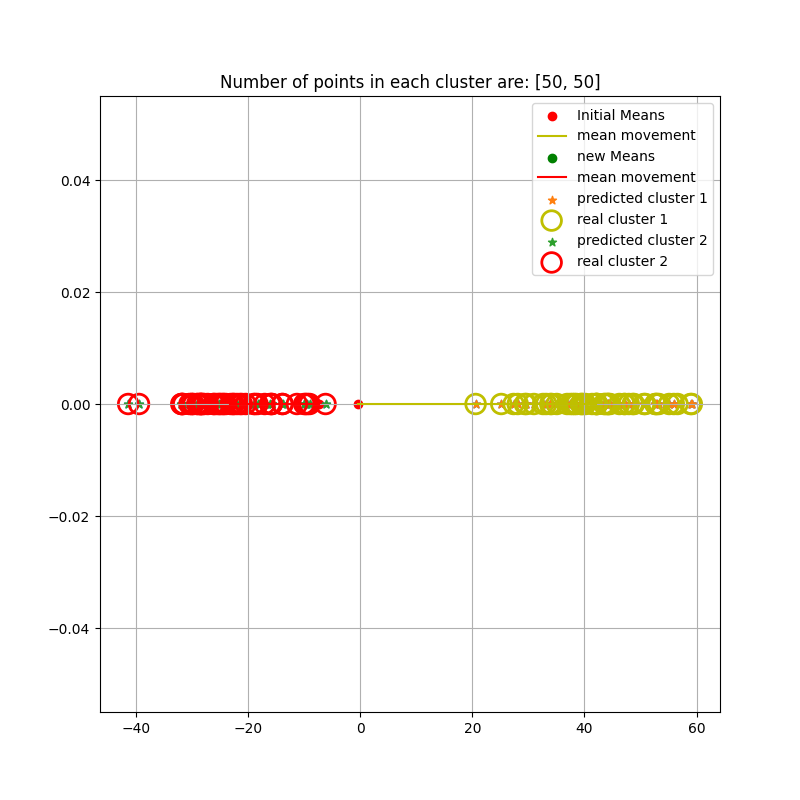

In [18]:
max_iterations = 5

kmeans1d = kmeans(dimensions=1, sample_size=100, clusters=2, tolerance=1e-8, max_iters=max_iterations)
# animation.FuncAnimation(kmeans1d.fig, kmeans1d.kmeans_iter, init_func=kmeans1d.kmeans_init ,frames=max_iterations, interval=(1/fps)*1000, repeat=False).save('./kmeans_1D.mp4', writer=writer);